# Analysis of NYC Public Schools SHSAT Data

This is a an exercise for my thinkful Data Science Course.

Raj Prasad, May 2019

[html version](https://daddyprasad5.github.io/children.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/children.ipynb) - with all the code exposed in an interactive notebook

There are 2 major sections to this document: 

* Background: Describes the SHSAT test, the NYC Specialized Schools, the PASSNYC organization, and the dataset used to investigate current test registration and take rates in one NYC district. 
* Research Proposal: A proposal for improving SHSAT test take rates. 

## Background

### SHSAT [link](https://www.schools.nyc.gov/school-life/learning/testing/specialized-high-school-admissions-test)

The Specialized high school admissions test (SHSAT) assesses knowledge and skills. These skills consist of the ability to comprehend English prose, to demonstrate understanding of revising and editing skills central to writing in English, and to use problem-solving skills in mathematics. The test measures knowledge and skills students have gained over the course of their education. 

The SHSAT is used for placement in NYC Specialized High Schools.  Students are ranked according to their score on the test and assigned to a school depending on their rank, the priority in which they placed schools on their application, and the seats available at each school. 

### NYC Specialized High Schools [link](https://en.wikipedia.org/wiki/Specialized_high_schools_in_New_York_City)

The specialized high schools of New York City are nine selective public high schools, established and run by the New York City Department of Education to serve the needs of academically and artistically gifted students.  The schools are: 

* The Bronx High School of Science
* Brooklyn Latin School
* Brooklyn Technical High School
* Fiorello H. LaGuardia High School of Music & Art and Performing Arts
* High School for Math, Science and Engineering at City College
* High School of American Studies at Lehman College
* Queens High School for the Sciences at York College
* Staten Island Technical High School
* Stuyvesant High School

### PASSNYC [link](http://www.passnyc.org/opportunity)

Promoting Access to Specialized Schools in New York City ("PASSNYC") focuses its efforts in underperforming areas that are historically underrepresented in SHSAT registration. In so doing, PASSNYC will help pave the path to specialized high schools for a more diverse group of students.

### District 5 & SHSAT Registration, Take, and Skip Rates

PASSNYC published an example dataset for district 5 (bronx) for 2013-16.  There are 30 schools in that district with students eligible for the SHSAT, and between 314-351 students from the district took the test each year.  

In [1]:
#imports and data load
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
#import psid_py as psid
%matplotlib inline

shsat = pd.read_csv("SHSAT_Registrations_and_Testers.csv")
schools = pd.read_csv("2016_School_Explorer.csv")

In [2]:
#data cleaning

#add registration, take and skip rate columns
shsat["reg_rate"] = (shsat["Number of students who registered for the SHSAT"] / 
                      shsat["Enrollment on 10/31"] )
shsat["take_rate"] = (shsat["Number of students who took the SHSAT"] / 
                      shsat["Enrollment on 10/31"] )
shsat["skip_rate"] = (1- (shsat["Number of students who took the SHSAT"] / 
                      shsat["Number of students who registered for the SHSAT"]))

#sort shsat by take rate
shsat[shsat.reg_rate>.9].sort_values("take_rate", ascending=False)

#remove spaces 
schools.columns.str.replace(' ','')

Index(['AdjustedGrade', 'New?', 'OtherLocationCodeinLCGMS', 'SchoolName',
       'SEDCode', 'LocationCode', 'District', 'Latitude', 'Longitude',
       'Address(Full)',
       ...
       'Grade8Math-AllStudentsTested', 'Grade8Math4s-AllStudents',
       'Grade8Math4s-AmericanIndianorAlaskaNative',
       'Grade8Math4s-BlackorAfricanAmerican', 'Grade8Math4s-HispanicorLatino',
       'Grade8Math4s-AsianorPacificIslander', 'Grade8Math4s-White',
       'Grade8Math4s-Multiracial', 'Grade8Math4s-LimitedEnglishProficient',
       'Grade8Math4s-EconomicallyDisadvantaged'],
      dtype='object', length=161)

In [3]:
#number of schools in district 5
len(shsat["School name"].unique())

30

In [4]:
# of eligible students / year and the SHSAT take rate per year
takers_by_year = shsat[["Number of students who took the SHSAT", "Year of SHST"]].groupby("Year of SHST").sum().reset_index()
eligible_by_year = shsat[["Enrollment on 10/31", "Year of SHST"]].groupby("Year of SHST").sum().reset_index()
overall_take_rates = pd.merge(left=eligible_by_year, right=takers_by_year, on="Year of SHST")
overall_take_rates["take_rate"] = overall_take_rates["Number of students who took the SHSAT"]  \
                                  / overall_take_rates["Enrollment on 10/31"]
overall_take_rates

,Year of SHST,Enrollment on 10/31,Number of students who took the SHSAT,take_rate
0,2013,3109,314,0.100997
1,2014,3243,347,0.107000
2,2015,3164,341,0.107775
3,2016,3360,351,0.104464


While most schools in the district have 50-120 students, most schools have fewer than 30 SHSAT registrants and fewer than 15 SHSAT takers.  As registration rate rises, skip rate also rises - i.e. schools with a higher percentage of registrants also see a greater percentage of those registrants fail to actually take the test. Despite this "skip-effect", higher registration rates still co-occur with higher take-rates.  

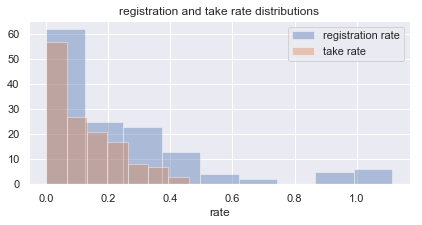

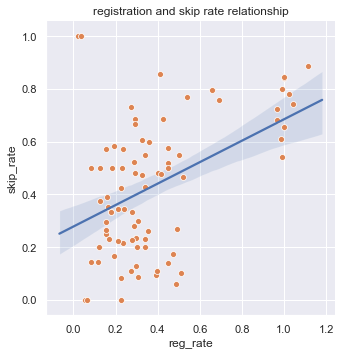

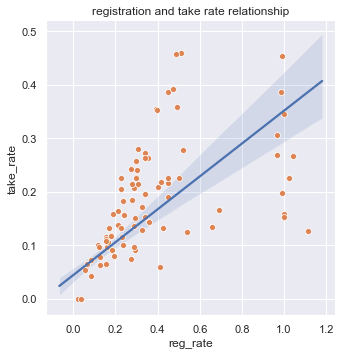

In [5]:
#distribution of, relationship bw, registration, skip & take rates

sns.set()
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1, title = "registration and take rate distributions")
sns.distplot(shsat.reg_rate, kde=False)
sns.distplot(shsat.take_rate, kde=False)
plt.legend(["registration rate", "take rate"])
plt.xlabel("rate")

ax2 = sns.lmplot(x="reg_rate", y="skip_rate", data=shsat, scatter=False)
ax2 = sns.scatterplot(x="reg_rate", y="skip_rate", data=shsat[shsat["Grade level"]==8])
plt.title("registration and skip rate relationship")
plt.show()

ax2 = sns.lmplot(x="reg_rate", y="take_rate", data=shsat, scatter=False)
ax2 = sns.scatterplot(x="reg_rate", y="take_rate", data=shsat[shsat["Grade level"]==8])
plt.title("registration and take rate relationship")
plt.show()


Several school characteristics appear to correlate (p >0.12) with test-taking behavior: 
* racial make-up
* % of students learning english as a second language
* % trust
* % collaborative teaching
* % effective leadership
* % supportive environment  

In [6]:
#merging to get at school demographic data
schools["name"] = schools["School Name"].str.strip().str.replace(" ", "").str.upper()
shsat["name"] = shsat["School name"].str.strip().str.replace(" ", "").str.upper()


d5 = shsat.merge(right=schools, how="left", on="name", indicator=True)

print("# of district 5 schools not present in schools data:  ",  \
      len(d5[d5["_merge"] == "left_only"]["name"].unique()))
print("average sum of students / year taking the test in all excluded schools:  ", \
      d5[["name", "Year of SHST", "Number of students who took the SHSAT"]]\
      [d5["_merge"] == "left_only"]\
          .groupby(["Year of SHST"]).sum().reset_index()["Number of students who took the SHSAT"].mean())




# of district 5 schools not present in schools data:   9
average sum of students / year taking the test in all excluded schools:   22.0


In [7]:
#further data cleaning to enable boxplots and t-tests

#assign take-rate bins
d5['take_rate_bin'] = \
    pd.cut(d5['take_rate'], [0, 0.10, 0.2, np.inf],
           labels=['0-0.15', '0.15-0.3', '0.3+'])
    

def conv_to_cents(df, col):
    if isinstance(df[col][0], str): 
        df[col] = pd.to_numeric(
            df[col].str.strip('$').str.replace(",", "").str.replace(".","")).head()
        
def conv_percent(df, col):
    if isinstance(df[col][0], str): 
        df[col]= pd.to_numeric(df[col].str.replace('%',''))

conv_to_cents(d5, "School Income Estimate")
conv_percent(d5, "Percent ELL")
conv_percent(d5, "Percent Asian")
conv_percent(d5, "Percent White")
conv_percent(d5, "Percent Black")
conv_percent(d5, "Percent Hispanic")
conv_percent(d5, "Percent Black / Hispanic")
conv_percent(d5, "Student Attendance Rate")
conv_percent(d5, "Percent of Students Chronically Absent")
conv_percent(d5, "Rigorous Instruction %")
conv_percent(d5, "Collaborative Teachers %")
conv_percent(d5, "Supportive Environment %")
conv_percent(d5, "Effective School Leadership %")
conv_percent(d5, "Strong Family-Community Ties %")
conv_percent(d5, "Trust %")







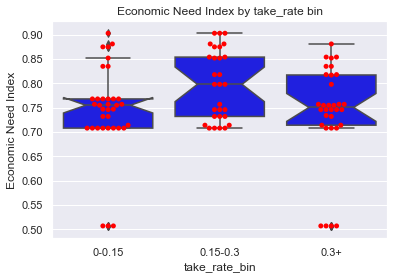

Ttest_indResult(statistic=-2.6749803270877055, pvalue=0.021729528507068455)


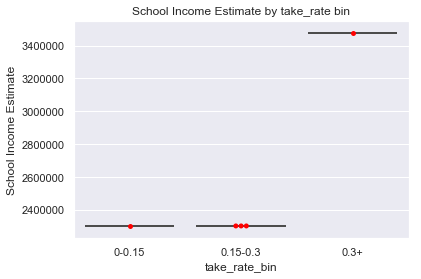

Ttest_indResult(statistic=masked, pvalue=masked_array(data=--,
             mask=True,
       fill_value=1e+20,
            dtype=float64))


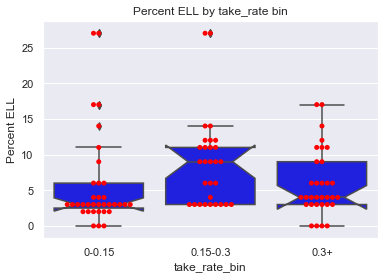

Ttest_indResult(statistic=-3.453047015645117, pvalue=0.0023840556320731347)


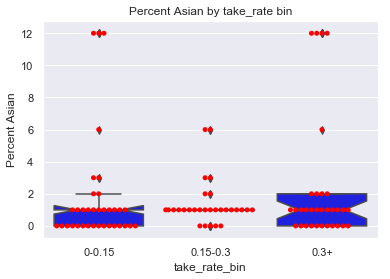

Ttest_indResult(statistic=1.9341156493179719, pvalue=0.08065472801355711)


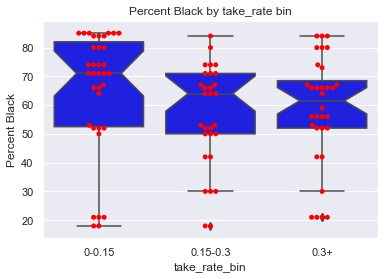

Ttest_indResult(statistic=-1.7420905661951633, pvalue=0.10799546466320961)


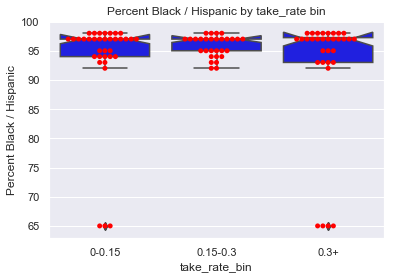

Ttest_indResult(statistic=-1.943811629825334, pvalue=0.07958253338664567)


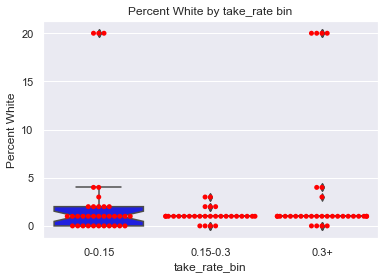

Ttest_indResult(statistic=2.088638999083116, pvalue=0.06231196404764243)


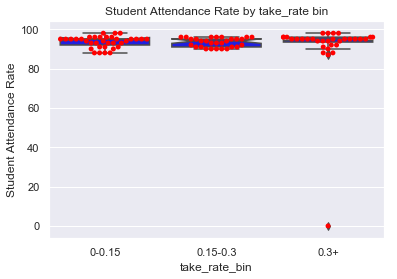

Ttest_indResult(statistic=-0.7032426796573972, pvalue=0.49792143475232387)


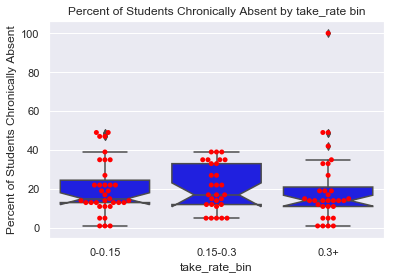

In [ ]:
#box plots and t-tests:  what school characteristics vary with test-taking behavior?

columns_of_interest = ["Economic Need Index", "School Income Estimate",
                      "Percent ELL", "Percent Asian", "Percent Black", 
                      "Percent Black / Hispanic", "Percent White", 
                      "Student Attendance Rate","Percent of Students Chronically Absent",
                      "Rigorous Instruction %", 
                      "Collaborative Teachers %", "Supportive Environment %", 
                       "Effective School Leadership %", "Strong Family-Community Ties %", 
                      "Trust %"]

#adds prints box-plot of a given continuous numeric column for each take-rate bin
def box_take_rate(compare_column):
    ax1 = sns.boxplot(x="take_rate_bin", y=compare_column, data=d5, notch=True, color="blue")
    ax1 = sns.swarmplot(x="take_rate_bin", y=compare_column, data=d5, color = "red")
    plt.title(compare_column + " by take_rate bin")
    plt.show()
    
    from scipy.stats import ttest_ind

    greater_than_3 = d5[d5.take_rate >= 0.3][compare_column]
    less_than_3 = d5[d5.take_rate < 0.3][compare_column]

    print(ttest_ind(greater_than_3, less_than_3, equal_var=False, nan_policy='omit'))
    
for col in columns_of_interest: box_take_rate(col)

## Research Proposal

### Problem 
Roughly a third of the 8th graders applying to the City's public high schools sit for the SHSAT, with only 6% (5,000 students) receiving admission offers. The vast majority of these go to students from "feeder" schools that represent less than one fifth of the total number of middle schools in the City.

We need to improve registration and take rates in schools with a high proportion of under-privileged students to improve the effectiveness of these schools in improving the lot of underprivileged students. 

### Potential Solution
The current process to register for the SHSAT is "opt-in" - i.e. students are registered if they take the initiative to proactively register.  One potential solution to low registration and take rates is to change to an opt-out process.  Default opt-in  has been proven effective in other situations by nobel laureate Richard Thaler in his book [Nudge](https://www.penguinrandomhouse.com/books/304634/nudge-by-richard-h-thaler-and-cass-r-sunstein/9780143115267/). I hypothesize that an opt-out process will improve take rates as compared to the current opt-in process. 

### Method
*Sampling & Group Assignment:*  

All schools in the city will be divided into cohorts based on similarities in the school characteristices (see "District 5 & SHSAT Registration, Take, and Skip Rates" above) that correlate with test-taking behavior.  

Each school in each cohort will be randomly assigned to one of two treatment groups: the control group receiving the current opt-in treatment, and the test group receiving the new opt-out treatment.  Half of all schools in each cohort will be in the test group. 

*Treatment:* 

The focus of this test will be on students with high grades in academic subject areas.  All 8th grade students in the top 30% by GPA in each schoool will be included in the research project.  These high-performing students in both test and control schools will receive a take-home slip indicating their enrollment status in the test.  Control group students will receive slips that indicate they are not registered, but they can check a box and return the slip to register.  Test group students will receive slips that indicate they are already registered, but they can check a box and return teh slip to un-register.  In all other respects, the two slips will be as much the same as is possible while being coherent.  If the slip is not returned the default option will remain in force.  

All registerd students will receive the same treatment leading up to the test (reminders, instructions, etc.) and on the test day itself.  

*Data Collection: * 

These variables will be collected (in addition to the school-level group assignment variables listed above): 
* school
* final registration status (post slip return)
* race
* date of birth
* test-taker status
* test result (accepted to school or not)
* matriculation status (attended first day at special school or not)

### Evaluation Plan

For each of the cohorts (see group assignment above) the null hypothesis will be rejected if the test-taking rate of the test group exceeds the rate of the control group (p < 0.05).   If the null hypothesis is rejected, then a move to a broad opt-out program for the test will be proposed to the city school board.  

In addition, I will compare test result and matriculation rates between the two groups.  It's possible that those "nudged" into taking the test may be less likely to pass the test and/or matriculate.  Improving test-taking rates are worthwhile in any case, but this data may prove useful in identifying the need for further intervention lower in the funnel.

A follow-up study will be conducted in five years to compare graduation rates across the two groups.